# ENVIROMENT SETTING

In [19]:
# COLAB ONLY
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# # setup for lightgbm gpu
# !git clone --recursive https://github.com/Microsoft/LightGBM
# %cd LightGBM
# !mkdir build
# %cd build
# !cmake ../../LightGBM
# !make -j4
# %cd LightGBM/python-package
# !python3 setup.py install --gpu
# !pip install cmake

In [21]:
# Octopus ML pakage - github.com/gershonc/octopus-ml
# !pip install octopus-ml
# !pip install catboost
!pip install bayesian-optimization

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# import octopus_ml as oc
import sklearn as sk
import glob

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD

from multiprocessing.pool import ThreadPool
from multiprocessing import Pool 
from scipy.stats import ks_2samp

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier
import xgboost as xgb
# from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier
import lightgbm as lgb

#### Data loading

In [4]:
folder_path = '/content/drive/MyDrive/Data/colabs_data/WiDS' #Kaggle: ../input/widsdatathon2021/ #Local PC: '.'
# raw features
# pd.read_csv(folder_path + "/TrainingWiDS2021.csv")
# pd.read_csv(folder_path + "/UnlabeledWiDS2021.csv")
# derived features
# df_train = pd.read_csv(folder_path + "/Data/train.csv")
# df_test = pd.read_csv(folder_path + "/Data/test.csv")

# New transformed data
df_full = pd.read_csv(folder_path + "/WiDS2021/Wids2021_full_feature_v5.csv")

# RIÊNG BỘ DỮ LIỆU 20210222 CẦN ĐỔI LẠI TYPE CHO 64 CỘT BOOLEAN, REPLACE INF VỚI NAN
cols_boolean = df_full.select_dtypes(include= 'boolean').columns
df_full[cols_boolean] = df_full[cols_boolean].astype('int')
df_full.replace([np.inf, -np.inf], np.nan, inplace = True)

# SỬA LẠI CỘT apache_2_diagnosis
def _clean_apache_2_diagnosis(x):
  try:
    out = str(int(float(x)))
  except:
    out = x
  return out
df_full['apache_2_diagnosis'] = df_full['apache_2_diagnosis'].apply(_clean_apache_2_diagnosis )

In [5]:
df_train = df_full[df_full['diabetes_mellitus'].notnull()]
df_test = df_full[df_full['diabetes_mellitus'].isnull()]
print(df_train.shape)
print(df_test.shape)

(130157, 1393)
(10234, 1393)


In [ ]:
print("train info: \n", df_train.info() )
print("test info: \n", df_test.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 0 to 130156
Columns: 1393 entries, Unnamed: 0 to knn_value_512
dtypes: float64(1072), int64(317), object(4)
memory usage: 1.4+ GB
train info: 
 None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10234 entries, 130157 to 140390
Columns: 1393 entries, Unnamed: 0 to knn_value_512
dtypes: float64(1072), int64(317), object(4)
memory usage: 108.8+ MB
test info: 
 None


In [24]:
# Bộ feature 2020
folder_path = '/content/drive/MyDrive/Data/colabs_data/WiDS' #Kaggle: ../input/widsdatathon2021/ #Local PC: '.'
# derived features
df_train = pd.read_csv(folder_path + "/WiDS2021/train_df_2020features.csv")
df_test = pd.read_csv(folder_path + "/WiDS2021/test_df_2020features.csv")

# Đổi dạng bool thành int
cols_boolean = df_train.select_dtypes(include= 'boolean').columns
df_train[cols_boolean] = df_train[cols_boolean].astype('int')
df_test[cols_boolean] = df_test[cols_boolean].astype('int')
df_train.replace([np.inf, -np.inf], 0, inplace = True)
df_test.replace([np.inf, -np.inf], 0, inplace = True)

# Data type 
col_target = 'diabetes_mellitus'
cols_id = ['encounter_id', 'Unnamed: 0', 'Unnamed: 0.1','knn_value_16', 'knn_value_512', 'knn_value_64' ]# , 'total_chronic', 'has_complicator', 'has_history', 'apache_hist'
cols_cat = [i for i in df_train.select_dtypes('object').columns if i not in cols_id + [col_target]]
cols_num = [i for i in df_train if i not in cols_cat + cols_id + [col_target] ]
cols_ft = cols_cat + cols_num

#### Feature classification
Phân loại các loại nhãn dữ liệu cần xử lý


In [6]:
# Data type 
col_target = 'diabetes_mellitus'
cols_id = ['encounter_id', 'Unnamed: 0', 'Unnamed: 0.1', 'hospital_id' ]# , 'total_chronic', 'has_complicator', 'has_history', 'apache_hist'
cols_cat = [i for i in df_train.select_dtypes('object').columns if i not in cols_id + [col_target]]
cols_num = [i for i in df_train if i not in cols_cat + cols_id + [col_target] ]
cols_ft = cols_cat + cols_num

### Điền missing values

In [ ]:
# raw fts
raw_df_train = pd.read_csv(folder_path + "/TrainingWiDS2021.csv")
raw_df_test = pd.read_csv(folder_path + "/UnlabeledWiDS2021.csv")
raw_df_test[col_target] = np.nan 
raw_df_full = pd.concat([raw_df_train, raw_df_test])

In [ ]:
try:
  df_full.set_index('encounter_id', inplace=True)
  raw_df_full.set_index('encounter_id', inplace=True)
except:
  pass

In [ ]:
done_num_cols = []

In [ ]:
# List cột cần fillna
raw_cols_num = [i for i in raw_df_full.select_dtypes(['int', 'float']) 
								if i not in ['encounter_id', 'Unnamed: 0', 'Unnamed: 0.1', 'hospital_id' ]+done_num_cols]
# MISSING VALUE MODEL
for col in raw_cols_num:
    print('processing at col:', col)
    ms_cols_ft = [i for i in df_full.select_dtypes(['int', 'float']) 
				            if i not in [col, 'encounter_id', 'Unnamed: 0', 'Unnamed: 0.1', 'hospital_id' ]] # Không dùng cat cols
    # Có các cột đã bị xóa trong raw data thì dùng raw data để filter
    # try:
    #     ms_X_train = df_full[df_full[col].notnull()][ms_cols_ft].fillna(-1000)
    #     ms_y_train = df_full[col][df_full[col].notnull()]
    #     ms_X_test = df_full[df_full[col].isnull()][ms_cols_ft].fillna(-1000)
    # except:
    ms_X_train = df_full[raw_df_full[col].notnull()][ms_cols_ft].fillna(-1000)
    ms_y_train = raw_df_full[col][raw_df_full[col].notnull()]
    ms_X_test = df_full[raw_df_full[col].isnull()][ms_cols_ft].fillna(-1000)
    if len(ms_X_test) > 0:
        # Turning model
        params = {
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'learning_rate': 0.007,
                'subsample': 1,
                'colsample_bytree': 0.25,
                'reg_alpha': 3,
                'reg_lambda': 1,
                'scale_pos_weight': 3,
                'n_estimators': 100,
                'verbose': 1,
                'max_depth': -1,
                'seed':100, 
                'force_col_wise': True
        }

        lgb_train = lgb.Dataset(ms_X_train, ms_y_train)
        ms_model = lgb.train(params, lgb_train, 160)
        raw_df_full[col][raw_df_full[col].isnull()] = ms_model.predict(ms_X_test)

processing at col: age


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


processing at col: bmi
processing at col: elective_surgery
processing at col: height
processing at col: icu_id
processing at col: pre_icu_los_days
processing at col: readmission_status
processing at col: weight
processing at col: albumin_apache
processing at col: apache_2_diagnosis
processing at col: apache_3j_diagnosis
processing at col: apache_post_operative
processing at col: arf_apache
processing at col: bilirubin_apache
processing at col: bun_apache
processing at col: creatinine_apache
processing at col: fio2_apache
processing at col: gcs_eyes_apache
processing at col: gcs_motor_apache
processing at col: gcs_unable_apache
processing at col: gcs_verbal_apache
processing at col: glucose_apache
processing at col: heart_rate_apache
processing at col: hematocrit_apache
processing at col: intubated_apache
processing at col: map_apache
processing at col: paco2_apache
processing at col: paco2_for_ph_apache
processing at col: pao2_apache
processing at col: ph_apache
processing at col: resp

In [ ]:
# xử lý missing cho biến categorical
# List cột cần fillna
raw_cols_cat = [i for i in raw_df_train.select_dtypes(['object']) 
								if i not in ['encounter_id', 'Unnamed: 0', 'Unnamed: 0.1', 'hospital_id' ]]
# MISSING VALUE MODEL
for col in raw_cols_cat:
    print('processing at col:', col)
    ms_cols_ft = [i for i in df_full.select_dtypes(['int', 'float']) 
					if i not in [col, 'encounter_id', 'Unnamed: 0', 'Unnamed: 0.1', 'hospital_id' ]] # Không dùng cat cols
    ms_X_train = df_full[df_full[col].notnull()][ms_cols_ft].fillna(-1000)
    le = preprocessing.LabelEncoder()
    ms_y_train = le.fit_transform( df_full[col][df_full[col].notnull()] )
    ms_X_test = df_full[df_full[col].isnull()][ms_cols_ft].fillna(-1000)

    # Turning model
    if len(ms_X_test) > 0:
        ms_model =  ensemble.RandomForestClassifier(n_estimators= 100, n_jobs= -1)
        ms_model.fit(ms_X_train, ms_y_train)
        raw_df_full[col][raw_df_full[col].isnull()] = le.inverse_transform( ms_model.predict(ms_X_test) )

processing at col: ethnicity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


processing at col: gender
processing at col: hospital_admit_source
processing at col: icu_admit_source


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


processing at col: icu_stay_type
processing at col: icu_type


In [ ]:
raw_df_full

,Unnamed: 0,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
214826,1,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.900000,2.300000,113.0,502.01,0,0,0.400000,31.000000,2.510000,0.565717,3.00000,6.000000,0.000000,4.00000,168.000000,118.0,27.400000,0,40.0,38.801456,38.801456,105.992719,7.305098,36.0,134.000000,...,9.335273,9.213095,28.900792,28.250812,1.259070,1.196667,2.010022,2.044563,153.912409,152.437064,3.760347,3.712578,130.910007,130.829559,10.756103,10.691901,33.782261,28.838500,7.253184,7.162695,111.229686,73.464938,183.145841,144.661305,31.645618,31.177549,7.186235,7.160934,112.044735,108.890299,158.456867,158.841160,0,0,0,0,0,0,0,1.000000
246060,2,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.200000,2.297812,108.0,203.01,0,0,0.856685,9.000000,0.560000,1.000000,1.00000,3.000000,0.000000,1.00000,145.000000,120.0,36.900000,0,46.0,37.000000,37.000000,51.000000,7.450000,33.0,145.000000,...,11.300000,11.300000,36.900000,36.900000,1.300000,1.300000,3.500000,3.500000,557.000000,557.000000,4.200000,4.200000,145.000000,145.000000,12.700000,12.700000,37.000000,37.000000,7.450000,7.450000,51.000000,51.000000,54.800000,51.000000,37.000000,37.000000,7.450000,7.450000,51.000000,51.000000,51.000000,51.000000,0,0,0,0,0,0,0,1.000000
276985,3,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.300000,2.931690,122.0,703.03,0,0,0.953587,20.112695,1.228308,0.552319,3.00000,6.000000,0.000000,5.00000,129.432379,102.0,34.627421,0,68.0,39.216058,39.216058,105.992719,7.307736,37.0,138.391827,...,8.750949,8.686773,27.716126,27.042132,1.258600,1.196233,1.885628,1.941686,113.931639,113.577725,3.706590,3.666160,128.959136,129.103955,8.166288,8.094545,34.022654,29.198786,7.254596,7.164186,111.052340,73.795915,183.542759,145.676096,31.730331,31.222836,7.186235,7.160934,112.119435,108.825393,159.008450,159.238012,0,0,0,0,0,0,0,0.000000
262220,4,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.700000,2.675006,203.0,1206.03,1,0,0.970654,23.713213,1.629495,0.600000,4.00000,6.000000,0.000000,5.00000,185.000000,114.0,25.900000,1,60.0,30.000000,30.000000,142.000000,7.390000,4.0,138.384484,...,11.600000,11.600000,34.000000,34.000000,1.600000,1.100000,1.885628,1.941686,43.000000,43.000000,3.830159,3.764867,128.965393,129.111143,8.800000,8.800000,37.000000,27.000000,7.440000,7.340000,337.000000,102.000000,342.500000,236.666667,36.000000,33.000000,7.370000,7.340000,337.000000,265.000000,337.000000,337.000000,0,0,0,0,0,0,0,0.000000
201746,5,33,19.0,23.745541,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,M

In [ ]:
raw_df_full.to_csv(folder_path +'/WiDS2021/raw_full_data_predict_missing_ft_20210225.csv', index = False)

### Ensemble model

In [ ]:
file_list = glob.glob(folder_path+'/WiDS2021/ensemble_outputs' +'/*.csv')
[i[71:] for i in file_list]

In [ ]:
weight_ensembles = {
#     'octopus_submission.csv':0.115384615384615,
# 'catboost_submission.csv':0,
# 'octopus_submission2.csv':0.115384615384615,
# 'rf_20210223_1066ft_submission.csv':0.0384615384615385,
# 'lgbm_submission3.csv':0.115384615384615,
# 'lgbm_bayes_opt_submission.csv':0.0769230769230769,
# 'lgbm_bayes_opt_submission2.csv':0.0769230769230769,
# 'lgbm_bayes_opt_submission_data_v4.csv':0.0769230769230769,
# 'lgbm_bayes_opt_submission_data_v4_3kearlystop.csv':0.0769230769230769,
'lgbm_linhntn_0.871_30k.csv': 0.5,
'submission_cp_lightGBM.csv': 0.5}

for file in weight_ensembles:
  file_path = folder_path+'/WiDS2021/ensemble_outputs' +'/'+file
  weight = weight_ensembles[file]
  try:
    ss_i = pd.read_csv(file_path)
    ss[col_target] += ss_i[col_target]*weight 
  except:
    ss = pd.read_csv(file_path)

ss.to_csv(folder_path +'/ensemble2_submission.csv', index = False)

### Model 1: XGBoost

In [ ]:
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -10000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
  ('predictor', XGBClassifier(n_estimators= 100, n_jobs= -1, max_depth = 5 ))
])

cv_auc = cross_val_score( pipe, df_train[cols_ft], df_train[col_target], 
                         cv = 5, scoring = 'roc_auc', verbose = 1, n_jobs = -1)
pipe.fit(df_train[cols_ft], df_train[col_target])

print(cv_auc)
print(np.mean(cv_auc))
# Run với raw data, không thêm feature
# [0.85000521 0.84067354 0.83726405 0.7301786  0.8296305 ]
# => AUC at CV: 0.8175503796337711
# => AUC at LB: 0.70188

# Run với bộ feature đã được thêm (đên 20210222)
# [1.         1.         0.99999981 1.         1.        ]
# AUC at CV: 0.9999999616917048
# => AUC at LB: 0.5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.2min finished


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                       

[1.         1.         0.99999981 1.         1.        ]
0.9999999616917048


###### XGboost with bayes opt

In [5]:
dtrain = xgb.DMatrix(df_train[cols_ft], label = df_train[col_target])

In [6]:
def XGB_CV( max_depth, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree ):
    params = {# fixed params
              'booster' : 'gbtree', 'seed' : 1001,
              'eta' : 0.1,
              'objective' : 'binary:logistic',
              'nthread' : 4,
              'silent' : True,
              'eval_metric': 'auc',
              'gpu_id' : 0,
              'tree_method' : 'gpu_hist',
              # to search params
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              }
    xgbc = xgb.cv( params, dtrain, num_boost_round = 20000,
                    stratified = True, nfold = 5,
                   verbose_eval = 1000,
                    early_stopping_rounds = 500,
                    metrics = 'auc', show_stdv = True )
    
    return xgbc['test-auc-mean'].iloc[-1]

XGB_BO = BayesianOptimization(XGB_CV, 
	{
     'max_depth': (2, 12),
     'gamma': (0.001, 10.0),
     'min_child_weight': (0, 20),
     'max_delta_step': (0, 10),
     'subsample': (0.4, 1.0),
     'colsample_bytree' :(0.4, 1.0)
    })

XGB_BO.maximize(init_points=2, n_iter=5, acq='ei', xi=0.0)

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
[0]	train-auc:0.804711+0.00175364	test-auc:0.802505+0.00181517
[1000]	train-auc:0.945454+0.000669342	test-auc:0.872328+0.00331716
|  1        |  0.8732   |  0.7889   |  4.742    |  9.499    |  4.508    |  9.57     |  0.7517   |
[0]	train-auc:0.805349+0.00138051	test-auc:0.801294+0.00304499
|  2        |  0.8725   |  0.4406   |  5.791    |  5.233    |  5.557    |  3.977    |  0.6822   |
[0]	train-auc:0.831221+0.000738443	test-auc:0.807846+0.00549616
|  3        |  0.8677   |  0.7898   |  6.928    |  0.08892  |  11.48    |  19.91    |  0.4588   |
[0]	train-auc:0.774443+0.000861109	test-auc:0.774192+0.00333607
[1000]	train-auc:0.887996+0.000729728	test-auc:0.87037+0.00322403
[2000]	train-auc:0.902584+0.000696282	test-auc:0.87161+0.00339546
|  4        |  0.8718   |  0.7677   |  0.2065   |  9.54  

In [7]:
{'params': {'colsample_bytree': 0.6623171413042399,
  'gamma': 7.429124436351293,
  'max_delta_step': 1.925534385389871,
  'max_depth': 7.521248014230691,
  'min_child_weight': 13.348363228352282,
  'subsample': 0.6574632375557762},
 'target': 0.8701279999999999}
XGB_BO.max['params']

{'colsample_bytree': 0.7888830791688737,
 'gamma': 4.7424296800429175,
 'max_delta_step': 9.498869873848605,
 'max_depth': 4.508336667348262,
 'min_child_weight': 9.56973791182546,
 'subsample': 0.7516726936641032}

In [5]:
best_search = {'colsample_bytree': 0.7888830791688737,
 'gamma': 4.7424296800429175,
 'max_delta_step': 9.498869873848605,
 'max_depth': 4.508336667348262,
 'min_child_weight': 9.56973791182546,
 'subsample': 0.7516726936641032}

def get_params( max_depth, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree ):
    params = {# fixed params
              'booster' : 'gbtree', 'seed' : 1001,
              'eta' : 0.1,
              'objective' : 'binary:logistic',
              'nthread' : 4,
              'silent' : True,
              'eval_metric': 'auc',
              'gpu_id' : 0,
              'tree_method' : 'gpu_hist',
              # to search params
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              }
    return params

# Phân tập train/valid
# df_train.set_index('encounter_id', inplace = True)
# df_test.set_index('encounter_id', inplace = True)
X_train, X_valid, y_train, y_valid = train_test_split( df_train[cols_ft], df_train[col_target], train_size= 98000, random_state= 68)
to_train_data = xgb.DMatrix(X_train, y_train)
to_val_data = xgb.DMatrix(X_valid, y_valid)

In [ ]:
df_train

In [14]:
model = xgb.train( get_params(**best_search) , to_train_data, verbose_eval =200, evals = [(to_val_data, 'auc')],
                  num_boost_round = 20000, early_stopping_rounds = 500 )

[0]	auc-auc:0.80019
Will train until auc-auc hasn't improved in 500 rounds.
[200]	auc-auc:0.869083
[400]	auc-auc:0.871193
[600]	auc-auc:0.871519
[800]	auc-auc:0.870618
[1000]	auc-auc:0.870188
Stopping. Best iteration:
[528]	auc-auc:0.871618



In [15]:
# submit thành 3 file: train, valid, test prediction; y_pred của valid và y_true_valid sẽ được dùng để train 
file_name = 'xgboost_bayesopt_v2'

X_train['prediction'] = model.predict(to_train_data)
X_train['diabetes_mellitus'] = y_train

X_valid['prediction'] = model.predict(to_val_data)
X_valid['diabetes_mellitus'] = y_valid

df_test['diabetes_mellitus'] = model.predict( xgb.DMatrix(df_test[cols_ft]) )

# save to csv
X_train[['prediction', 'diabetes_mellitus']].to_csv(folder_path +'/WiDS2021/ensemble_outputs/stacking_train/train_'+file_name+'.csv', index = True)
X_valid[['prediction', 'diabetes_mellitus']].to_csv(folder_path +'/WiDS2021/ensemble_outputs/stacking_valid/valid_'+file_name+'.csv', index = True)
df_test[ 'diabetes_mellitus'].to_csv(folder_path +'/WiDS2021/ensemble_outputs/stacking_test/test_'+file_name+'.csv', index = True)

#### SUBMISSION for SKLEARN PIPELINE

In [ ]:
df_test['diabetes_mellitus'] = pipe.predict( df_test[cols_ft])
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/submission.csv', index = False)

### Model 2: OctopusML

In [ ]:
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -10000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
])

X = pd.DataFrame(data = pipe.fit_transform( df_train[cols_ft]), columns= cols_ft)
y = df_train[col_target]

# Turning model
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.007,
        'subsample': 1,
        'colsample_bytree': 0.25,
        'reg_alpha': 3,
        'reg_lambda': 1,
        'scale_pos_weight': 3,
        'n_estimators': 10000,
        'verbose': 1,
        'max_depth': -1,
        'seed':100, 
        'force_col_wise': True
}

lgb_train = lgb.Dataset(X, y, categorical_feature= cols_cat)
clf = lgb.train(params, lgb_train, 160)

# clf,arr_f1_weighted,arr_f1_macro,arr_f1_positive,prediction_folds,preds_folds,y_folds= oc.cv(
#     X, y,
#     0.5,16000,shuffle=True,params=params)

# Model với bộ dữ liệu gốc, 10k estimators
# => AUC at CV: 
# => AUC at LB: 0.86139

# Model với bộ dữ liệu mới, 1k estimators
# => AUC at CV: 
# => AUC at LB: 0.84526

# Model với bộ dữ liệu mới, 100k estimators
# => AUC at CV: 
# => AUC at LB: 

# Model với bộ dữ liệu 23/2 763fts, 10k estimators
# => AUC at CV: 
# => AUC at LB:      

# Model với bộ dữ liệu 23/2 1066fts, 10k estimators
# => AUC at CV:  
# => AUC at LB:      

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [ ]:
df_test['diabetes_mellitus'] = clf.predict(pipe.transform( df_test[cols_ft]))
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/lgbm_submission3.csv', index = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


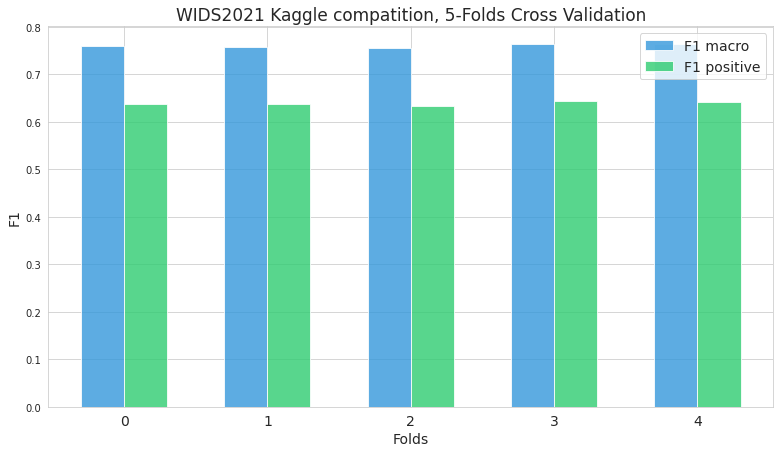

In [ ]:
# Model 2 
oc.cv_plot(arr_f1_weighted,arr_f1_macro,arr_f1_positive,'WIDS2021 Kaggle compatition')

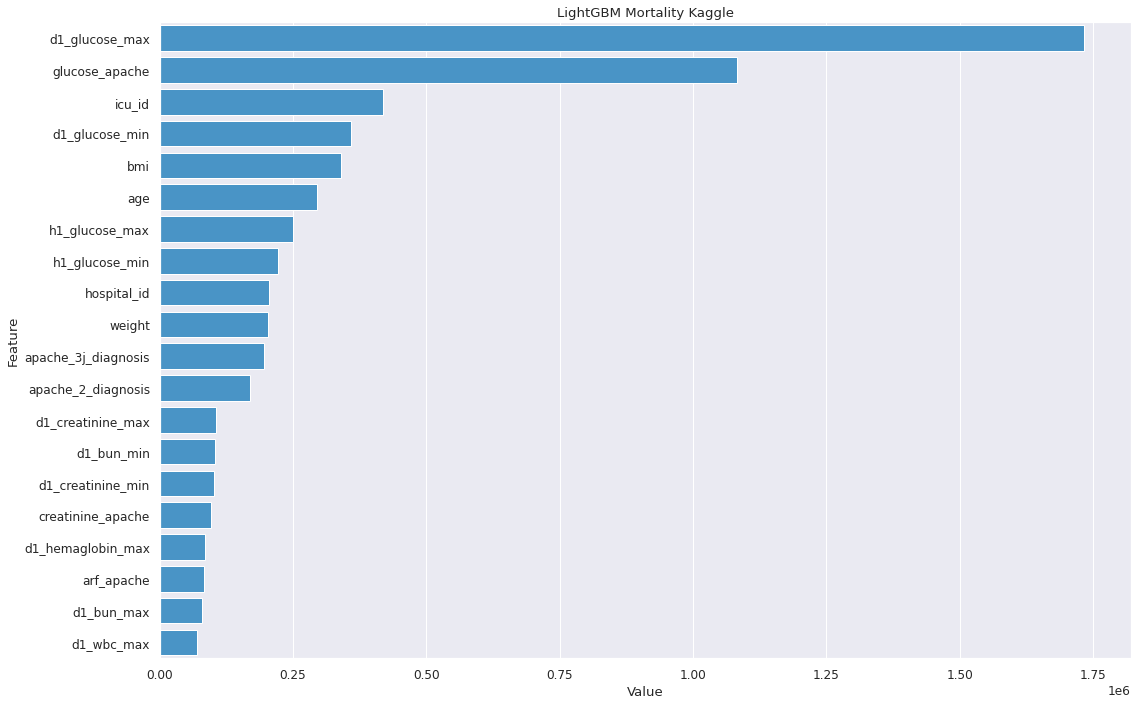

In [ ]:
# Model 2
feature_imp_list=oc.plot_imp(clf,X,'LightGBM Mortality Kaggle',num=20)

### Model 3: Random forest

In [ ]:
p_cat = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value='missing')) ,
  ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -1000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
  ('predictor', ensemble.RandomForestClassifier(n_estimators= 100, n_jobs= -1))
])

cv_auc = cross_val_score( pipe, df_train[cols_ft], df_train[col_target], 
                         cv = 2, scoring = 'roc_auc', verbose = 1, n_jobs = -1)

print(cv_auc)
print(np.mean(cv_auc))
pipe.fit(df_train[cols_ft], df_train[col_target])
# Run với bộ feature đã được thêm (đên 20210222)
# => AUC at CV: [0.99959688 0.99941862 0.99965045 0.99966624 0.99953139] 0.9995727162353532
# => AUC at LB: 0.50331
# => bị data leakage => loại bỏ ft có importance quá cao

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.1min finished


[0.99377653 0.99453443]
0.994155480434119


KeyboardInterrupt: ignored

                             ft_importance
total_chronic                     0.202069
has_complicator                   0.165993
has_history                       0.140659
apache_hist                       0.130909
glucose_max_mean_1                0.018073
total_cancer_immuno               0.013492
glucose_max_std_0                 0.013155
glucose_max_std_1                 0.012620
age_bmi_glu_max_d                 0.009652
glucose_max_mean_0                0.009309
glu_risk_200                      0.008833
glucose_d1_value_range            0.008675
d_max_glucose_risk_200            0.008179
d1_glucose_max                    0.007366
immunosuppression                 0.007101
gluco_high_risk                   0.006653
glucose_max_min_d                 0.006470
cirrhosis                         0.006370
glucose_apache                    0.005776
solid_tumor_with_metastasis       0.005372
hepatic_failure                   0.004905
glu_risk_140                      0.004854
h1_glucose_

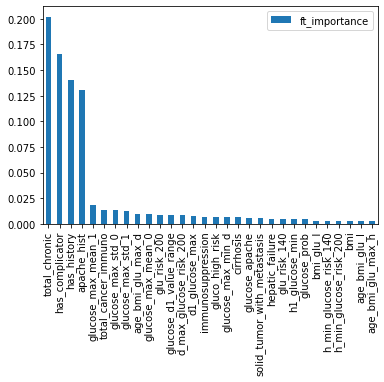

In [ ]:
ft_importance_df = pd.DataFrame.from_dict(dict(zip(cols_ft, pipe.named_steps['predictor'].feature_importances_)), orient='index', columns =['ft_importance'])
ft_importance_df.sort_values(by = 'ft_importance', ascending=False)[:30].plot(kind = 'bar')
print(ft_importance_df.sort_values(by = 'ft_importance', ascending=False)[:30])

### Model 4: ANN with tf feature column

In [ ]:
df_ft_full = pd.concat( [df_train[cols_ft], df_test[cols_ft]], axis = 0)
df_ft_full[cols_num] = df_ft_full[cols_num].fillna(df_ft_full[cols_num].mean())
df_ft_full[cols_cat] = df_ft_full[cols_cat].fillna('missing')
# df_ft_full = df_ft_full.reset_index(drop = True)
    
# df_ft_full[cols_cat] = df_ft_full[cols_cat].astype('object')
# df_ft_full[cols_num] = df_ft_full[cols_num].astype('float64')
df_train_full = pd.concat( [df_ft_full[:130157],df_train[[col_target]] ], axis = 1 )

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=128):
    dataframe = dataframe.copy()
    try:
        labels = dataframe.pop(col_target)
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    except:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
                                                
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    
    # For performance turning
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

batch_size = 2048 # A small batch sized is used for demonstration purposes

df_to_train, df_to_val = train_test_split(df_train_full, test_size = 0.2, shuffle=True)

ds_train = df_to_dataset(df_to_train, batch_size=batch_size)
ds_val = df_to_dataset(df_to_val, shuffle=False, batch_size=batch_size)
ds_test = df_to_dataset(df_ft_full[130157:], shuffle=False, batch_size=batch_size)

# Check data is correct
for feature_batch, label_batch in ds_train.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['gender'])
    print('A batch of targets:', label_batch )

# FEATURE COLUMNS
fcs_num = [tf.feature_column.numeric_column(i) for i in cols_num]
fcs_cat = [
    tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            col, vocabulary_list = list(df_ft_full[col].drop_duplicates() )
        ), dimension = int(len(df_ft_full[col].drop_duplicates() ) * 0.15) +2
    )
    for col in cols_cat
]


Every feature: ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_diagnosis', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', '

In [ ]:

# MLP Nets
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(fcs_num ),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(1024, activation = 'relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(512, activation = 'relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(64, activation = 'relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.015), 
              metrics = [tf.keras.metrics.AUC()])
history = model.fit( ds_train, validation_data = ds_val,
                   epochs = 10, batch_size = 128)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
51/51 [==============================] - 30s 378ms/step - loss: 2534.6913 - auc: 0.4949
Epoch 2/10
51/51 [==============================] - 1s 20ms/step - loss: 1351.0450 - auc: 0.4975
Epoch 3/10
51/51 [==============================] - 1s 19ms/step - loss: 492.3982 - auc: 0.5449
Epoch 4/10
51/51 [==============================] - 1s 20ms/step - loss: 171.1960 - auc: 0.6113
Epoch 5/10
51/51 [==============================] - 1s 20ms/step - loss: 62.6805 - auc: 0.6354
Epoch 6/10
51/51 [==============================] - 1s 20ms/step - loss: 26.1346 - auc: 0.6348
Epoch 7/10
51/51 [==============================] - 1s 20ms/step - loss: 20.6199 - auc: 0.6264
Epoch 8/10
51/51 [==============================] - 1s 21ms/step - loss: 14.5392 - auc: 0.6268
Epoch 9/10
51/51 [==============================] - 1s 20ms/step - loss: 25.0115 - auc: 0.5928
Epoch 10/10
51/51 [========

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_10 (DenseFeat multiple                  0         
_________________________________________________________________
dense_40 (Dense)             multiple                  299       
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________


<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'AUC')

Text(0.5, 0, 'Epochs')

NameError: ignored

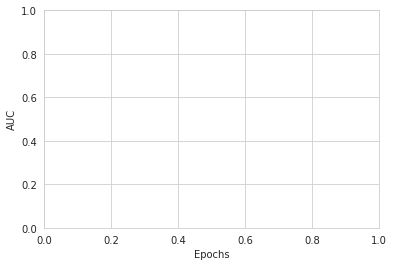

In [ ]:
# Exam results
plt.figure()
plt.ylabel("AUC")
plt.xlabel("Epochs")
# plt.ylim([0,2])
plt.plot(history.history['val_auc'],label='Validation')
plt.plot(history.history['auc'], label='Train')
plt.legend(loc='lower center', shadow=True, fontsize='medium')

### Model 5: Catboost

In [ ]:
p_cat = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
  # ('encode', preprocessing.OrdinalEncoder())
])
p_num = Pipeline([
  ('fillna', SimpleImputer(strategy='constant', fill_value= -10000))
])
p1 = ColumnTransformer([
  ('cat', p_cat, cols_cat),
  ('num', p_num, cols_num)
])

pipe = Pipeline([
  ('transformer', p1),
])

# X = pd.DataFrame(data = pipe.fit_transform( df_train[cols_ft]), columns= cols_ft)
# y = df_train[col_target]
df_to_train, df_to_val = train_test_split(df_train, test_size = 0.2, shuffle=True)

X_train = pd.DataFrame(data = pipe.fit_transform( df_to_train[cols_ft]), columns= cols_ft)
y_train = df_to_train[col_target]

X_val = pd.DataFrame(data = pipe.transform( df_to_val[cols_ft]), columns= cols_ft)
y_val = df_to_val[col_target]

model = CatBoostClassifier(eval_metric='AUC', task_type="GPU", use_best_model=True, early_stopping_rounds=20)
    # verbose=True, task_type="GPU",depth=5, eval_metric="AUC",
    #                        iterations=1600,
    #                        learning_rate=0.06,
    #                        metric_period=4)
model.fit(X_train,y_train,
          cat_features= cols_cat,
          eval_set = (X_val, y_val), # ONLY IF use_best_model=True
          cat_features = cols_cat,
          plot=True,silent=True)
print(model.get_best_score())

# Sử dụng lại catboost với bộ ft 23/2; depth = 10
# => AUC at Train: 0.9560662508010864
# => AUC at LB: 0.69966

# Sử dụng lại catboost với bộ ft 23/2; depth = 5
# => AUC at Train: 0.8786202073097229
# => AUC at LB: 0.70308

# catboost ft 23/2, use_best_model = True
# => AUC at Train: 0.8755195736885071
# => AUC at Valid: 0.8592059910297394
# => AUC at LB: 0.69550

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Logloss': 0.3496606767707083, 'AUC': 0.8744245171546936}, 'validation': {'Logloss': 0.3698656566317417, 'AUC': 0.8578012585639954}}


In [ ]:
df_test['diabetes_mellitus'] = model.predict(pipe.transform( df_test[cols_ft]))
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/catboost_submission.csv', index = False)

### Model 6: LGBM

In [ ]:
# Without categorical columns| 20210225
best_params =  {'bagging_fraction': 0.8766805307530916,
  'feature_fraction': 0.8642027679654405,
  'lambda_l1': 4.912602026444597,
  'lambda_l2': 2.437499183488889,
  'learning_rate': 0.02501159905983583,
  'min_child_weight': 10.077249918461563,
  'min_split_gain': 0.05624653693483012,
  'num_leaves': 32.35902690851246,
  'scale_pos_weight': 0.7903383094151535}
  
def lgb_params( params ):
    params2 = {'boosting_type': 'dart', 'device' : 'cpu','application':'binary', 'early_stopping_round':400, 
               'metric':'auc', 'max_depth':-1, 'force_col_wise': True}
    params['feature_fraction'] = max(min(params['feature_fraction'], 1), 0)
    params['bagging_fraction'] = max(min(params['bagging_fraction'], 1), 0)
    params['num_leaves'] = int(round(params['num_leaves']))
    params['lambda_l1'] = max(params['lambda_l1'], 0)
    params['learning_rate'] = max(params['learning_rate'], 0)
    params['lambda_l2'] = max(params['lambda_l2'], 0)
    return dict( params, **params2)

X = df_train[cols_num].fillna( df_train[cols_num].mean() )
y = df_train[col_target]
X_train, X_valid, y_train, y_valid = train_test_split( df_train[cols_ft], df_train[col_target], train_size= 98000, random_state= 68)
to_train_data = lgb.Dataset(X_train, y_train)
to_val_data = lgb.Dataset(X_valid, y_valid)

model = lgb.train( lgb_params(best_params) , to_train_data, verbose_eval =200, 
                    valid_sets = to_val_data, num_boost_round = 5500 )

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's auc: 0.840789
[400]	valid_0's auc: 0.85145
[600]	valid_0's auc: 0.85938
[800]	valid_0's auc: 0.863382
[1000]	valid_0's auc: 0.866134
[1200]	valid_0's auc: 0.867992
[1400]	valid_0's auc: 0.869842
[1600]	valid_0's auc: 0.870945
[1800]	valid_0's auc: 0.872242
[2000]	valid_0's auc: 0.872915
[2200]	valid_0's auc: 0.873628
[2400]	valid_0's auc: 0.874376
[2600]	valid_0's auc: 0.87468
[2800]	valid_0's auc: 0.874826
[3000]	valid_0's auc: 0.875119
[3200]	valid_0's auc: 0.875266
[3400]	valid_0's auc: 0.875713
[3600]	valid_0's auc: 0.875853
[3800]	valid_0's auc: 0.87594
[4000]	valid_0's auc: 0.876136
[4200]	valid_0's auc: 0.876232
[4400]	valid_0's auc: 0.876312
[4600]	valid_0's auc: 0.876329
[4800]	valid_0's auc: 0.87644
[5000]	valid_0's auc: 0.876504
[5200]	valid_0's auc: 0.87649


In [17]:
# submit thành 3 file: train, valid, test prediction; y_pred của valid và y_true_valid sẽ được dùng để train 
file_name = 'lgbm_bayesopt_v2_cv8744'

X_train['prediction'] = model.predict(X_train)
X_train['diabetes_mellitus'] = y_train

X_valid['prediction'] = model.predict(X_valid)
X_valid['diabetes_mellitus'] = y_valid

df_test['diabetes_mellitus'] = model.predict( df_test[cols_ft] )

# save to csv
X_train[['prediction', 'diabetes_mellitus']].to_csv(folder_path +'/WiDS2021/ensemble_outputs/stacking_train/train_'+file_name+'.csv', index = True)
X_valid[['prediction', 'diabetes_mellitus']].to_csv(folder_path +'/WiDS2021/ensemble_outputs/stacking_valid/valid_'+file_name+'.csv', index = True)
df_test[ 'diabetes_mellitus'].to_csv(folder_path +'/WiDS2021/ensemble_outputs/stacking_test/test_'+file_name+'.csv', index = True)

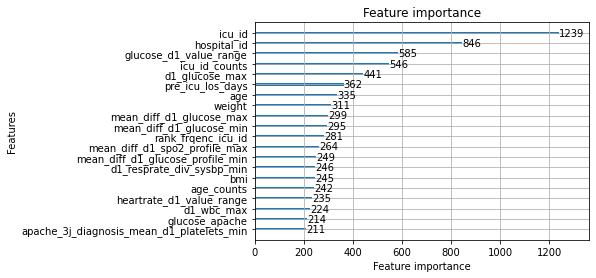

In [18]:
lgb.plot_importance(model, max_num_features  = 20)

# SUBMISSION

In [ ]:
df_test['diabetes_mellitus'] = clf.predict(pipe.transform( df_test[cols_ft]))
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv(folder_path +'/submission.csv', index = False)

## CHECK ERROR

In [ ]:
for i in cols_cat:
  test_and_not_train = [t for t in df_test[i].unique() if t not in df_train[i].unique()]
  if len(test_and_not_train) !=0:
    print('column with value in test data but not train: ', i, ' ; \n value: ', test_and_not_train)
  train_and_not_test = [t for t in df_train[i].unique() if t not in df_test[i].unique()]
  if len(train_and_not_test) != 0:
    print('column with value in train data but not test: ', i, ' ; \n value: ', train_and_not_test)


column with value in test data but not train:  ethnicity  ; 
 value:  [nan]
column with value in train data but not test:  ethnicity  ; 
 value:  [nan]
column with value in test data but not train:  gender  ; 
 value:  [nan]
column with value in train data but not test:  gender  ; 
 value:  [nan]
column with value in test data but not train:  hospital_admit_source  ; 
 value:  [nan]
column with value in train data but not test:  hospital_admit_source  ; 
 value:  [nan, 'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other']
column with value in test data but not train:  icu_admit_source  ; 
 value:  [nan]
column with value in train data but not test:  icu_admit_source  ; 
 value:  [nan]


In [ ]:
# hospital_admit_source  
print(df_train['hospital_admit_source'].unique())
print(df_test['hospital_admit_source'].unique())

['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']
['Floor' 'Emergency Department' 'Direct Admit' nan 'Operating Room'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Step-Down Unit (SDU)' 'Chest Pain Center']


In [ ]:
df_train[i].unique()

array(['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU',
       'Cardiac ICU', 'CSICU'], dtype=object)

In [ ]:
'CTICU' not in df_test[i].unique()

False

In [ ]:
# # Kiểm tra vì sao pipe bị lỗi
# pipe[0].transformers[0][1].fit(df_train[cols_cat])
# pipe[0].transformers[0][1].transform(df_test[cols_cat])
# # =>cat pipe work well
# pipe[0].transformers[1][1].fit(df_train[cols_num])
# pipe[0].transformers[1][1].transform(df_test[cols_num])
# # =>num pipe work well

# pipe[0].fit(df_train[cols_ft])
# pipe[0].transform(df_test[cols_ft])
# # # => all pipe work well

array([[ 2.,  0.,  4., ...,  0.,  0.,  0.],
       [ 2.,  0.,  3., ...,  0.,  0.,  0.],
       [ 2.,  0.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  0., 14., ...,  0.,  0.,  0.],
       [ 2.,  0.,  3., ...,  0.,  0.,  0.],
       [ 2.,  1.,  3., ...,  0.,  0.,  0.]])

In [ ]:
pipe.predict(df_test[cols_ft])

XGBoostError: ignored

# LOG

In [ ]:
'''
20210221
Model1: Run với raw data, không thêm feature => XGboost đơn giản
[0.85000521 0.84067354 0.83726405 0.7301786  0.8296305 ]
=> AUC at CV: 0.8175503796337711
=> AUC at LB: 0.70188

Model với bộ dữ liệu gốc, không thêm features, 10k estimators, train với octopus ML 
training rất lâu nhưng hiệu quả là tốt
=> AUC at CV: 
=> AUC at LB: 0.86139

20210222

'''